<font size="10"> **Spanish Electricity Pool Forecasting: Neural Network Model Building** <font size="10">

This notebook goal is to build a Machine Learning model that forecast the next period spot price. 

Remember that a model is just a representation of an actual process that generates the output. This representation tries to accomplish two items:
1. Capture every input feature that affects this process.
2. Quantify (set up rules or a formula coeffcients) the relationship between these input features and the outcome.

$$ \text{Target: } Y $$

$$ \text{Actual feature space: } X={X_{1}, X_{2}, ..., X_{m}, X_{m+1}, X_{X_m+2}, X_{X_m+m'}} $$

$$ \text{Actual process: } Y = H(X) +\epsilon $$

Where $\epsilon$ stands for the random nature of the process, errors in data measuring or missed parts of the actual feature space.

$$ \text{Predicted target: } \hat{Y} \simeq Y$$

$$ \text{Input feature space: } X={X_{1}, X_{2}, ..., X_{m}} $$

$$ \text{Approximation function (Model): } \hat{Y} = F(X_{1}, X_{2}, ..., X_{m}) $$



Regaring step 1:
Sometimes not every input feature that take part in the actual process is known or data is not available, so even if actual process behavior is known, our representation will be an approximation.

Therefore the first step is to collecta data, with the objective of arranging a set of input features (variables) that may affect our ouput variable (target). In EDA step, some sort of feature selection can be done, but for the sake of argument, let's assume it does not.

Regarding step 2:
To sum up, a model is approximation function that maps from features inputs X (dealt with in step 1) to a target Y. There are many algorithms that will aproximate this function, once  one of them is chosen, the next step is Model  building. It is a complex task fulfilled in two overlapping steps:
* Hyperparameter tunning: It is the process of deciding model structure, that will determine model ability to fit data current data and generalize to future data.
* Model training: For a particular model structure, come up with concrete instance (fitted coefficients or rules) fitted to data, that can yield predictions. 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
import xgboost as xgb
import pickle

import mle_utils.predictions as mle_preds
import mle_utils.timeseries_cv as mle_tscv

In [2]:
import config
sns.set(
    rc=config.set_plot_features(), style="darkgrid"
       )

In [3]:
PATH = './data/'
DEPLOY_PATH = "./models/"
DEPLOY_MODEL_NAME = 'MLP_V01_2019_31_05.sav'
infile = 'data_spot_price_forecasting.csv'

In [4]:
data = pd.read_csv(PATH + infile, parse_dates=['date'], index_col=['date'])
data.head()

,year,qtr,mon,weekday,flg_isWeekend,target_spot_price_t1,target_spot_price_t2,target_spot_price_t3,target_spot_price_t4,target_spot_price_t5,...,feat_spot_price_std_mave7,feat_spot_price_std_mstd7,feat_spot_price_std_mmax7,feat_spot_price_std_mmin7,feat_spot_price_std_mave7_lag365,feat_spot_price_std_mave30,feat_spot_price_std_mstd30,feat_spot_price_std_mmax30,feat_spot_price_std_mmin30,feat_spot_price_std_mave30_lag365
date,,,,,,,,,,,,,,,,,,,,,
2015-01-30,2015,1,1,4,0,17.177917,16.530833,48.258750,43.392917,39.519167,...,-0.046528,0.689057,0.664920,-1.122178,-1.867873,0.304629,0.559314,1.269743,-1.122178,-1.132475
2015-01-31,2015,1,1,5,1,16.530833,48.258750,43.392917,39.519167,42.649583,...,-0.362832,1.111102,0.664920,-2.341153,-1.880878,0.231418,0.736007,1.269743,-2.341153,-1.049138
2015-02-01,2015,1,2,6,1,48.258750,43.392917,39.519167,42.649583,46.118750,...,-0.619616,1.353995,0.664920,-2.389290,-1.984005,0.137708,0.876471,1.269743,-2.389290,-1.084848
2015-02-02,2015,1,2,0,0,43.392917,39.519167,42.649583,46.118750,53.093333,...,-0.718754,1.266870,0.654598,-2.389290,-1.980999,0.124046,0.875745,1.269743,-2.389290,-1.118706
2015-02-03,2015,1,2,1,0,39.519167,42.649583,46.118750,53.093333,40.220000,...,-0.848232,1.161669,0.654598,-2.389290,-1.868904,0.118184,0.878677,1.269743,-2.389290,-1.065845


In [5]:
features = [x for x in list(data.columns) if "feat_" in x]
#Multiperiod forecasting
targets = [x for x in list(data.columns) if "target_" in x]
#Single period forecasting
target = targets[0]

In [6]:
len(features)

45

# Data train/test split

As evaluation strategy, two approach are followed:
* Evaluate in a test dataset, holding out 2019 data
* Compute Cross Validation mean error on train data, up to year 2018

Total number of observations:  1432
Train: (1432, 45)(1432,), 
Test: (132, 45)(132,)


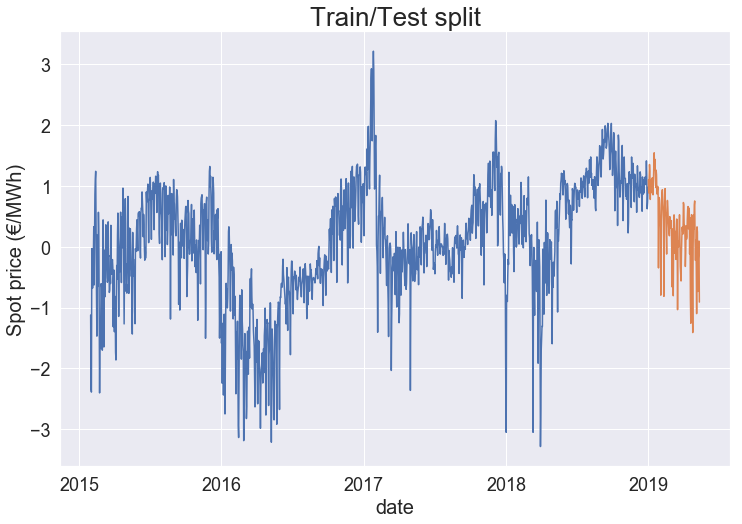

In [7]:
split_yr = 2019
X_train = data[:str(split_yr-1)][features]
y_train = data[:str(split_yr-1)][target]

X_test = data[str(split_yr):][features]
y_test = data[str(split_yr):][target]

idx_train = X_train.index.values
idx_test = X_test.index.values
nobs, p = X_train.shape

preds_df = data[[target]].copy()
preds_df["flg_isTrain"] = 1
preds_df.loc[idx_test, "flg_isTrain"] = 0


print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                              X_test.shape, y_test.shape))

X_train["feat_spot_price_std"].plot(label="train", figsize=(12, 8))
X_test["feat_spot_price_std"].plot(label="test")
plt.title("Train/Test split")
plt.ylabel("Spot price (€/MWh)")
plt.show()

# Baseline Model: Linear Regresion
The first candidate model that every Data Scientist MUST try is a linear one, it is an easy way to stablish a baseline forecasting and understand variance and noise in data.

In [8]:
lr = LinearRegression().fit(X_train, y_train)

In [9]:
p_train, RMSE_train, MAPE_train, R2_train = mle_preds.pred_and_score_model(model=lr, X=X_train, y=y_train, label="Train")

          RMSE      MAPE        R2
Train  4.85778  3.519757  0.858444


In [10]:
p_test, RMSE_test, MAPE_test, R2_test = mle_preds.pred_and_score_model(model=lr, X=X_test, y=y_test, label="Test")

          RMSE      MAPE        R2
Test  6.220598  4.909301  0.401159


In a forecasting problem, it is important to carry out a systematic residual diagnosis analysis. There are several ways, but the main goal are:
* Compare forecasted vs actual values to visually assess model performance
* Visualize residuals distribution to check normality
* Assess whether residuals variance is constant over time and over actual values

In [11]:
preds_df["p_lr"] = np.concatenate((p_train, p_test),axis=0)

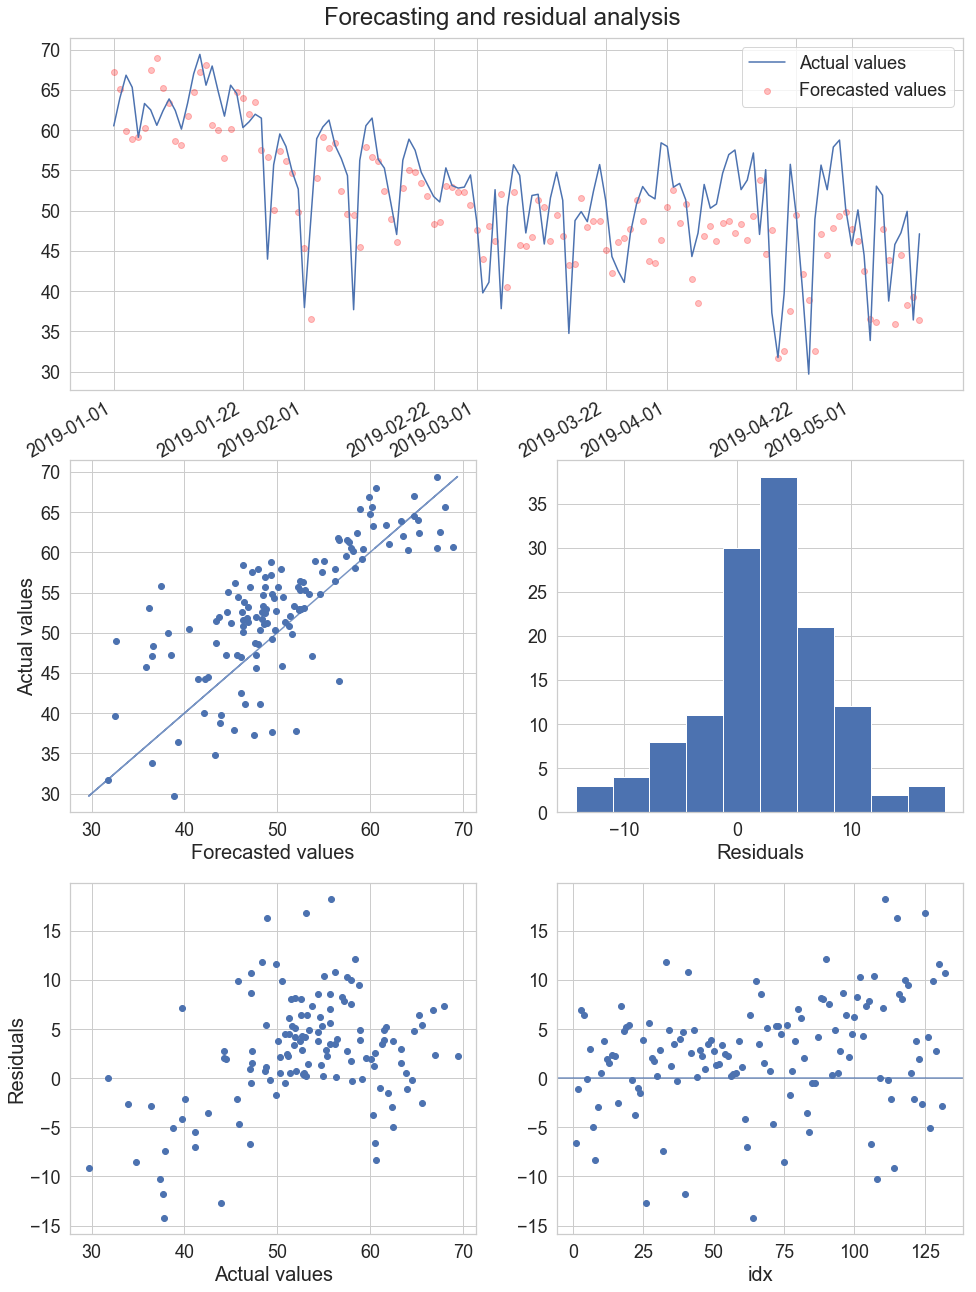

In [12]:
mle_preds.plot_predictions(y=y_test, p=p_test, time_index=idx_test)

Model performance is quite good it is able to capture properly trend and seasionality, RMSE is quite low and MAPE is over 5%, decent scores for a linear model, it proves that even a simple model with may features and data enough may be a good one.
Residual analysis shows that there is room for improvements, as conditions previously stated are not strictly fulfilled.

Let's try a cross-validation error assessment to perform a hollistic model performance

# Model Building

## Time series split

Regular cross-validation strategys are not appropiate to time series data, it is better to use a time series split, so validation data is always ahead train data. In scikit-learn, validation data size is hold fixed and train data grows, therefore first folds may not have data enough to train a double seasonal model

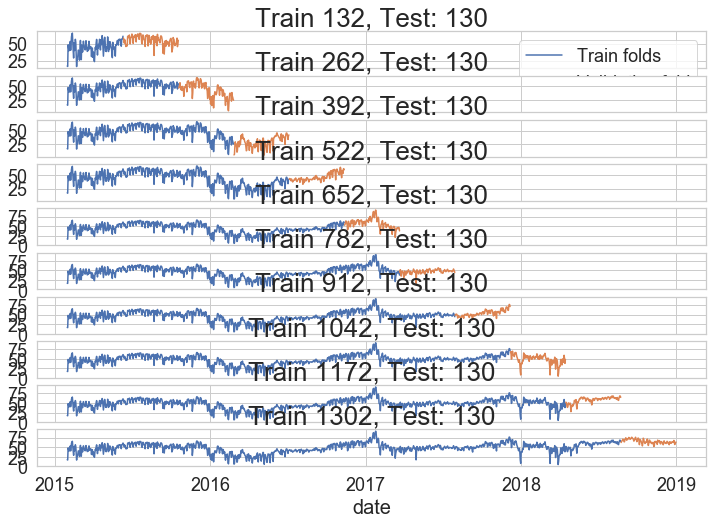

In [13]:
k_splits= 10
splits = TimeSeriesSplit(n_splits=k_splits, max_train_size=5*365)

fig, axs = plt.subplots(k_splits,1, sharex=True, figsize=(12,8))
i=0
for train_index, val_index in splits.split(X_train):    
    y_train[train_index].plot(ax=axs[i], label="Train folds")
    y_train[val_index].plot(ax=axs[i], label="Validation fold")
    axs[i].set_title("Train {}, Test: {}".format( len(train_index), len(val_index)))
    if i==0:
        axs[i].legend()
    i+=1
    
plt.show()

## Baseline model CV Error assessment

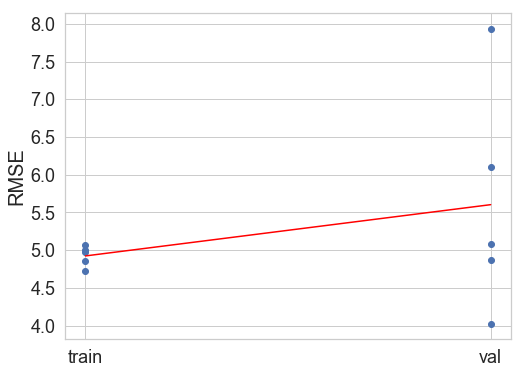

In [14]:
lr_cv_mean_train_score, lr_cv_mean_val_score, lr_kfold_train_scores, lr_kfold_val_scores =\
    mle_tscv.time_series_CV(model=lr, cv_splits=splits, min_train_len=2*365, X=X_train, y=y_train, plot=True)

Cross validation mean RMSE and test RMSE are quit similar, so the former can be a good proxy for the later 

## Lasso Regression: Hyperparameter Tunning

The next step is to use a more advanced model to forecast, as linear regression suffers from multicollinearity and some feature are highly correlated, the next model to try is a regularized regression. Let's try Lasso Regression that may yield an sparse model.

In [15]:
lr_lasso = Lasso(random_state=123)

param_lasso_dict = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100]} 
param_lasso_grid = ParameterGrid(param_lasso_dict)

lr_lasso, lasso_best_model_idx, lasso_train_cv_score, lasso_val_cv_score, lasso_cv_report_df =\
    mle_tscv.time_series_CV_grid_search(model=lr_lasso,param_grid=param_lasso_grid,
                                        cv_splits=splits, min_train_len=2*365,
                                        X=X_train,
                                        y=y_train.values,
                                        refit=True, dev=False)


======> CV algorithm finished after 6 hyperparameter configurations evaluated
Best model HyperParams:  {'alpha': 0.01}
Best model Train CV mean RMSE: 5.204743410906066 
Best model Val CV mean RMSE: 4.885118233451495


In [16]:
lasso_coefs = lr_lasso.coef_
lasso_coefs_df = pd.DataFrame(index=features, data=lasso_coefs, columns=["coefficients"]).sort_values(by="coefficients")
print("Zeroed coefficients: ", lasso_coefs_df[lasso_coefs_df["coefficients"]==0].index.values)

Zeroed coefficients:  ['feat_GP48_CC_pct' 'feat_spot_price_std_mmax30'
 'feat_spot_price_std_mstd30' 'feat_GP48_export_pct'
 'feat_GP48_import_pct' 'feat_GP48_cogen_pct' 'feat_GP48_PV_pct'
 'feat_spot_price_std_mave7_lag365' 'feat_GP48_nuclear_pct_mmax180'
 'feat_GP48_pumping_con_pct_mave180' 'feat_GP48_export_pct_mave180'
 'feat_GP48_hydro_total_pct' 'feat_GP48_biomass_pct'
 'feat_GP48_thermosolar_pct' 'feat_GP48_nuclear_pct'
 'feat_GP48_pumping_tur_pct_mave7' 'feat_GP48_pumping_tur_pct']


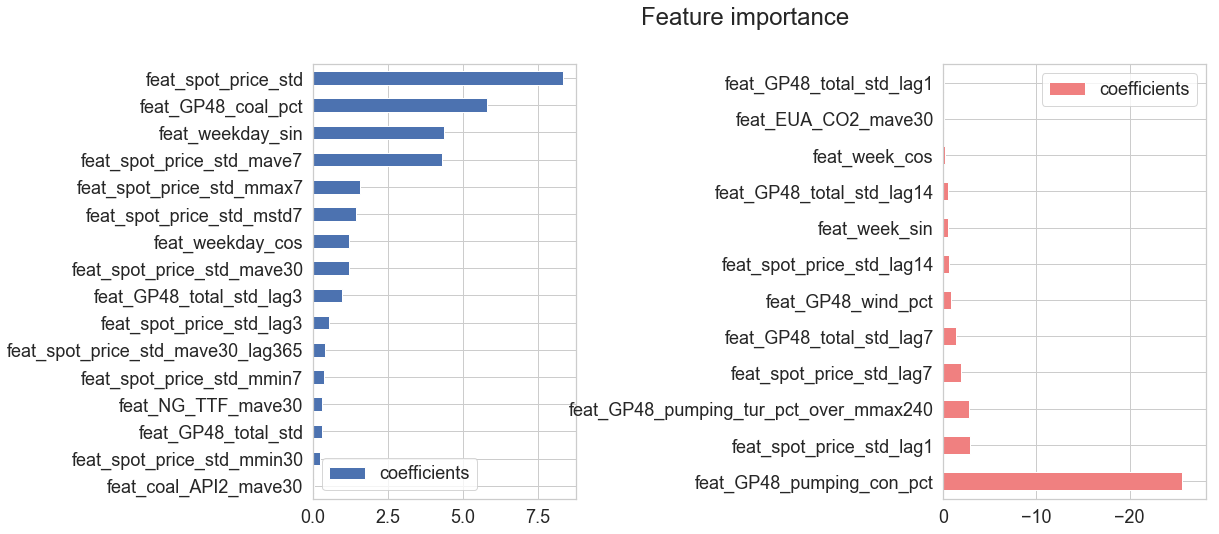

In [17]:
fig, axs = plt.subplots(1,3, figsize=(16,8))

lasso_coefs_df[lasso_coefs_df["coefficients"]>0].plot(kind="barh", ax=axs[0])
lasso_coefs_df[lasso_coefs_df["coefficients"]<0].plot(kind="barh", color ="lightcoral", ax=axs[2])
axs[2].set_xlim(0, lasso_coefs_df["coefficients"].head().values[0]*1.1)
plt.suptitle("Feature importance")
fig.delaxes(axs[1])

In [18]:
preds_df["p_lasso"] = np.concatenate((lr_lasso.predict(X_train), lr_lasso.predict(X_test)),axis=0)

## Neural Network: Hyperparameter Tunning

Neural Nets are parametric models like regressions, that can model any relationship. In theory, the can find complex relationships among features by adding more neurons over more layers. As there are may features and overfitting risk is high, let's try a small NN with only one layer

In [19]:
nn = MLPRegressor(activation ='relu', early_stopping=False, 
                    solver='adam', beta_1=0.9, beta_2=0.999, epsilon=1e-8,
                    random_state=123, verbose=False)

param_mlp_dict = {'hidden_layer_sizes':[(2), (3), (5)],
                  'max_iter': [2000],
                  'batch_size': [64],
                  'learning_rate_init': [0.005],
                  'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 250, 500, 750, 1000]
} 


param_mlp_grid = ParameterGrid(param_mlp_dict)

nn, nn_best_model_idx, nn_train_cv_score, nn_val_cv_score, nn_cv_report_df = mle_tscv.time_series_CV_grid_search(model=nn,
                                                                      param_grid=param_mlp_grid,
                                                                      cv_splits=splits,  min_train_len=2*365,
                                                                      X=X_train,
                                                                      y=y_train.values,
                                                                      refit=True, dev=False)


======> CV algorithm finished after 30 hyperparameter configurations evaluated
Best model HyperParams:  {'max_iter': 2000, 'learning_rate_init': 0.005, 'hidden_layer_sizes': 2, 'batch_size': 64, 'alpha': 0.1}
Best model Train CV mean RMSE: 5.388595840261763 
Best model Val CV mean RMSE: 6.493784586418391


Mean cross validation score does not improve, remember that in this dataset, overfitting is risky, because there are many features. Moreover, scikit-learn Neural Net implementation does not provide many regularizing tools

In [20]:
preds_df["p_nn"] = np.concatenate((nn.predict(X_train), nn.predict(X_test)),axis=0)

## Random Forest: Hyperparameter Tunning

The best candidates of non-parametric models are Decission treess ensembles. There are two main ensembles:
* Random forest (RFs)
* Gradient boosting trees (GBMs)

A randon forest fits several independent decision trees performing a technique bagging (boostrap aggregating). It basically samples observations and features in order to obtain a set of non correlated trees
Whereas GBMs fits trees sequentially to residuals, so it continuously improves predicion until it starts to overfit. A concrete (and very powerfull) implementation of GBMs is called eXtreme Gradient Boosting machines (XGBs)

In [21]:
rf = RandomForestRegressor(n_estimators=300, criterion = "mse", max_features = "sqrt", bootstrap =True, oob_score = True, n_jobs=-1, random_state = 123,  verbose=False)


param_rf_dict = {'max_depth':[3, 5, 10, 15, 20 ,25],
                  'min_samples_split': [5,10,25],
                  'min_samples_leaf': [5,10, 25]} 
param_rf_grid = ParameterGrid(param_rf_dict)


rf, rf_best_model_idx, rf_train_cv_score, rf_val_cv_score, rf_cv_report_df= mle_tscv.time_series_CV_grid_search(model=rf,
                                                                      param_grid=param_rf_grid,
                                                                      cv_splits=splits,  min_train_len=2*365,
                                                                      X=X_train,
                                                                      y=y_train.values,
                                                                      refit=True, dev=False)



======> CV algorithm finished after 54 hyperparameter configurations evaluated
Best model HyperParams:  {'min_samples_split': 25, 'min_samples_leaf': 10, 'max_depth': 10}
Best model Train CV mean RMSE: 4.879262947018317 
Best model Val CV mean RMSE: 5.0861440934184765


In [22]:
preds_df["p_rf"] = np.concatenate((rf.predict(X_train), rf.predict(X_test)),axis=0)

Random forest yields a good result, but it does not improve lasso regression results, however it also provides an insigth of feature importance

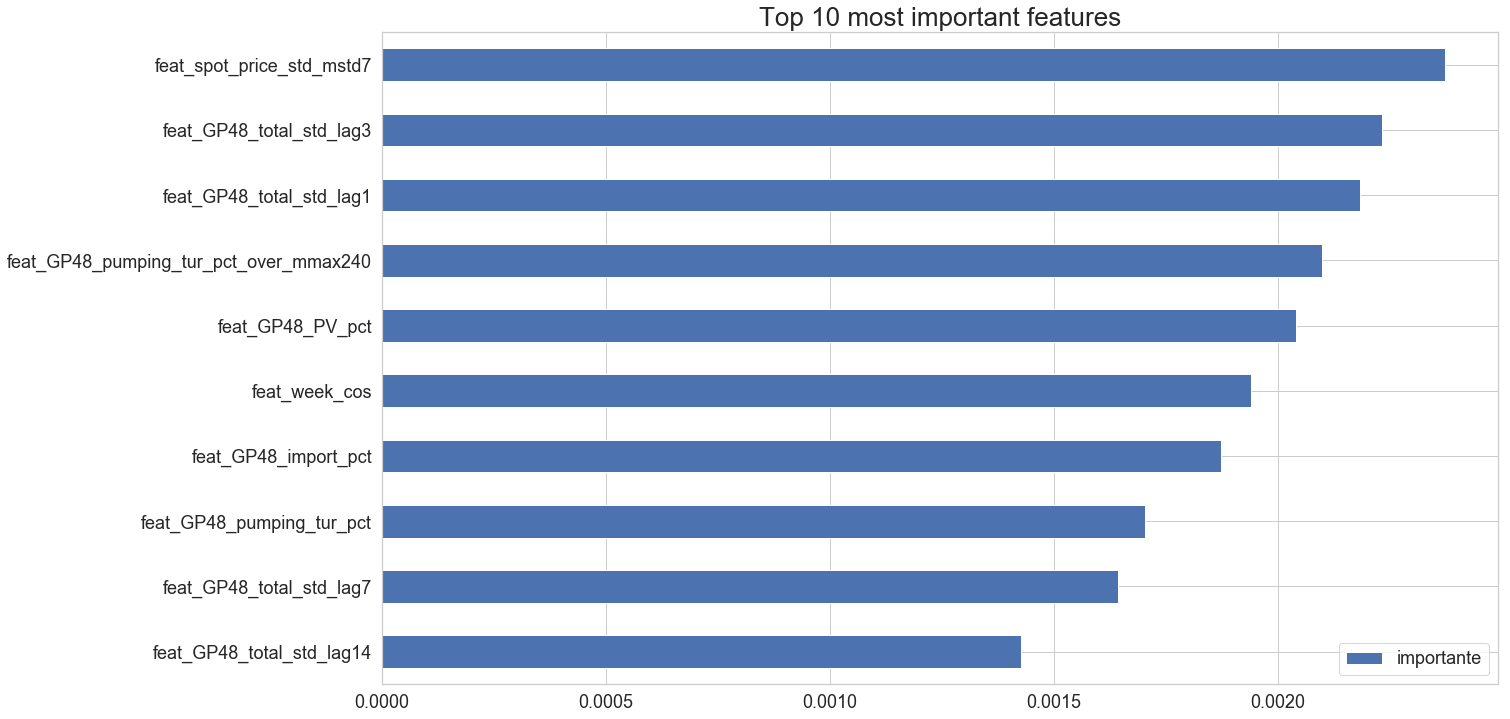

In [23]:
rf_features_imp = rf.feature_importances_
rf_feat_imp_df = pd.DataFrame(index=features, data=rf_features_imp, columns=["importante"]).sort_values(by="importante")
rf_feat_imp_df.head(10).plot(kind="barh")
plt.title("Top 10 most important features")
plt.show()

## XGB: Hyperparameter Tunning

In [24]:
xgb_params = {
    'colsample_bytree': [0.6],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 3, 5],
    "lambda" : [100, 50, 10, 1, 0.1], "alpha": [0.0],
    "eta": [0.1, 0.01]
}

# Instantiate the regressor: gbm
xgb = xgb.XGBRegressor(random_state=123, n_jobs =-1, objective="reg:linear")

param_xgb_grid = ParameterGrid(xgb_params)


xgb, xgb_best_model_idx, xgb_train_cv_score, xgb_val_cv_score, xgb_cv_report_df= mle_tscv.time_series_CV_grid_search(model=xgb,
                                                                      param_grid=param_xgb_grid,
                                                                      cv_splits=splits,  min_train_len=2*365,
                                                                      X=X_train,
                                                                      y=y_train.values,
                                                                      refit=True, dev=False)


======> CV algorithm finished after 120 hyperparameter configurations evaluated
Best model HyperParams:  {'n_estimators': 100, 'max_depth': 2, 'lambda': 100, 'eta': 0.1, 'colsample_bytree': 0.6, 'alpha': 0.0}
Best model Train CV mean RMSE: 4.036308323443975 
Best model Val CV mean RMSE: 4.641112637836257


In [25]:
preds_df["p_xgb"] = np.concatenate((xgb.predict(X_train), xgb.predict(X_test)), axis=0)

In [34]:
preds_df["e_xgb"] = preds_df["target_spot_price_t1"]-preds_df["p_xgb"]
preds_df["e_abs_xgb"] = abs(preds_df["e_xgb"])
preds_df["e_abs_pct_xgb"] = preds_df["e_abs_xgb"]/preds_df["target_spot_price_t1"]
preds_df.groupby("flg_isTrain")["e_abs_pct_xgb"].mean().to_frame("MAPE")

,MAPE
flg_isTrain,
0,0.089142
1,0.082985


In [36]:
p_train, RMSE_train, MAPE_train, R2_train = mle_preds.pred_and_score_model(model=xgb, X=X_train, y=y_train, label="Train")

           RMSE      MAPE        R2
Train  4.150385  3.067569  0.896669


In [35]:
p_test, RMSE_test, MAPE_test, R2_test = mle_preds.pred_and_score_model(model=xgb, X=X_test, y=y_test, label="Test")

          RMSE      MAPE        R2
Test  5.457412  4.260543  0.539085


Finally, XGB improves lasso regression results!

## Model selection and residual analysis

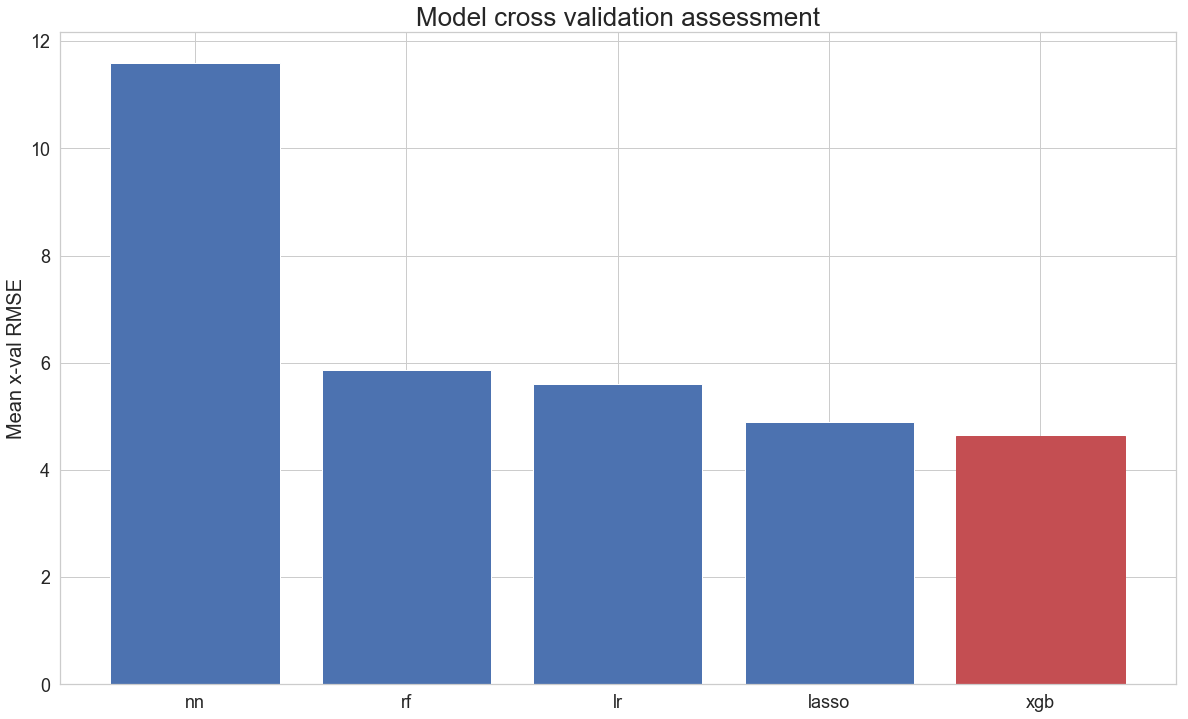

In [26]:
models = ["lr", "lasso", "nn", "rf", "xgb"]
xval_report_df = pd.DataFrame(index=models, 
             data={"train": [lr_cv_mean_train_score,
                             lasso_train_cv_score[xgb_best_model_idx],
                             nn_train_cv_score[xgb_best_model_idx],
                             rf_train_cv_score[xgb_best_model_idx],
                             xgb_train_cv_score[xgb_best_model_idx]],
                  "val": [lr_cv_mean_val_score,
                          lasso_val_cv_score[xgb_best_model_idx],
                          nn_val_cv_score[xgb_best_model_idx],
                          rf_val_cv_score[xgb_best_model_idx],
                          xgb_val_cv_score[xgb_best_model_idx]]}
            )

xval_report_df.sort_values(by="val", ascending=False, inplace=True)
x_tickers = xval_report_df.index.values
y_values = xval_report_df["val"].values
barplot = plt.bar(x_tickers, y_values)
barplot[-1].set_color("r")
plt.title("Model cross validation assessment")
plt.ylabel("Mean x-val RMSE")
plt.show()

It can be clearly seen that xgb is the best model, due to its low x-val average RMSE

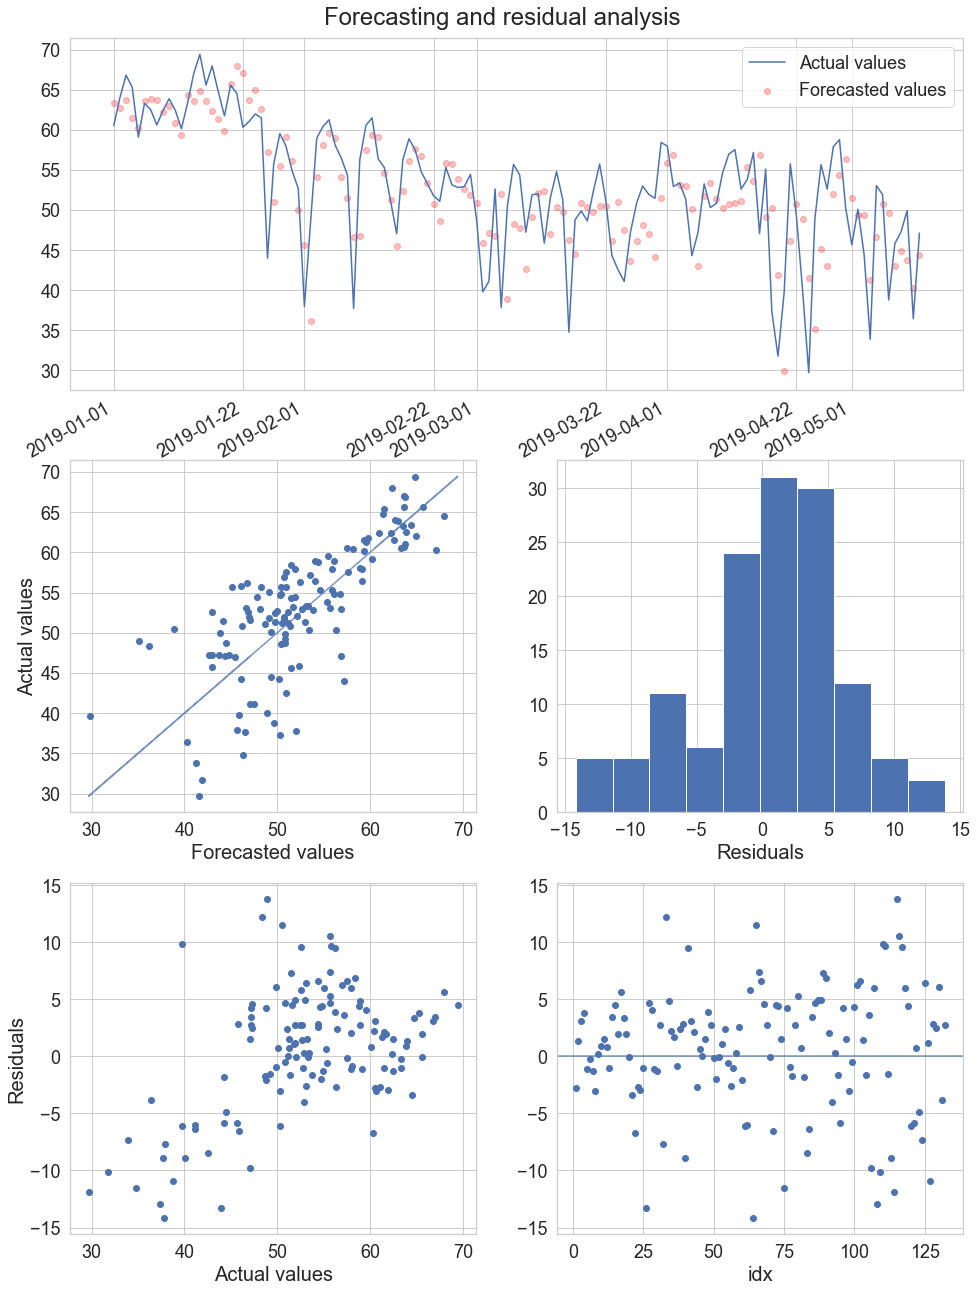

In [27]:
p_train =  xgb.predict(X_train)
p_test = xgb.predict(X_test)
mle_preds.plot_predictions(y=y_test, p=p_test, time_index=idx_test)

Even though model performance is pretty good, when looking at residual analysis, two flaws can be detected:
* Residuals are left skewed
* Residuals variance over time is constant, but plotted against actual values, when spot price is low, the model tends to under predict. 

To further improve prediction accuracy, it is suggested to analyze if this issue is due to weekend effect and add a flag that models it.

## Model Ensemble: Weighted Average

The easiest way to combine predictions is to average model forecast weighting by x-val score

In [28]:
w = 1/xval_report_df.loc[["xgb", "lr"], "val"]
w = w/w.sum()
w

xgb    0.546981
lr     0.453019
Name: val, dtype: float64

In [29]:
preds_df["p_ens"] = (preds_df["p_xgb"]*w["xgb"] + preds_df["p_lasso"]*w["lr"])/w.sum()
preds_df["r_ens"] = (preds_df["target_spot_price_t1"] - preds_df["p_ens"])**2
preds_df.groupby("flg_isTrain")["r_ens"].mean().apply(np.sqrt).to_frame("Ensemble Test RMSE")

,Ensemble Test RMSE
flg_isTrain,
0,5.646762
1,4.420697


In [30]:
preds_df["r_xgb"] = (preds_df["target_spot_price_t1"] - preds_df["p_xgb"])**2
preds_df.groupby("flg_isTrain")["r_xgb"].mean().apply(np.sqrt).to_frame("XGB Test RMSE")

,XGB Test RMSE
flg_isTrain,
0,5.457412
1,4.150385


This basic ensembling strategy does not improve results over XGB model, but it ilustrates a general approach to further improve forecasting models

In [31]:
pickle.dump(xgb, open(DEPLOY_PATH + DEPLOY_MODEL_NAME, 'wb'))

In [32]:
!ls -lrt ./models

total 108
-rw-r--r-- 1 manua 197609 62211 may. 30 21:48 MLP_V01_2019_30_05.sav
-rw-r--r-- 1 manua 197609 42674 jul. 18 23:45 MLP_V01_2019_31_05.sav
